In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from regions import Regions
import numpy as np
from astropy import units as u
from astropy.nddata import Cutout2D
import pandas as pd
import cv2
from split_image import split_image
import os
import random
from random import seed
import shutil
from skimage.io import imread,imshow
from skimage.transform import resize
from tqdm import tqdm
import tensorflow as tf
import tensorboard

# Preparing images for the input layer

In [8]:
seed = 42

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '../../../../../../Applications/PHYS499/dataset01dim50/stage1_train/'

train_ids = next(os.walk(TRAIN_PATH))[1]

X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=bool)


print('Resizing training images and masks')
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True)
    X_train[n] = img
    mask_ = imread(path + '/mask/' + id_,as_gray=True)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True),axis=-1)
    Y_train[n] = mask_

Resizing training images and masks


100%|███████████████████████████████████████| 1695/1695 [00:28<00:00, 59.96it/s]


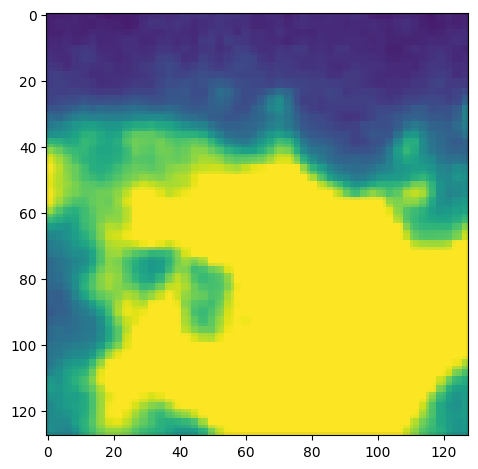

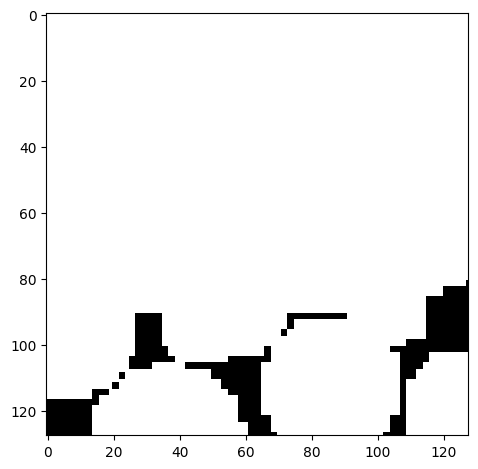

In [10]:
image_x = random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

# U-NET Architecture

In [11]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)


#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)


outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()



Metal device set to: Apple M1


2023-03-25 01:47:50.513674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-25 01:47:50.513824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

In [12]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('bubbles.h5',verbose=1,save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=64,epochs=50,callbacks=callbacks)


Epoch 1/50


2023-03-25 01:47:51.137700: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-25 01:47:51.938387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5626

2023-03-25 01:48:05.832638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 16s 136ms/step - loss: 0.6885 - accuracy: 0.5626 - val_loss: 0.6877 - val_accuracy: 0.5565
Epoch 2/50
96/96 [==============================] - 11s 119ms/step - loss: 0.6852 - accuracy: 0.5567 - val_loss: 0.6833 - val_accuracy: 0.5649
Epoch 3/50
96/96 [==============================] - 11s 120ms/step - loss: 0.6825 - accuracy: 0.5725 - val_loss: 0.6800 - val_accuracy: 0.5847
Epoch 4/50
96/96 [==============================] - 11s 119ms/step - loss: 0.6667 - accuracy: 0.6012 - val_loss: 0.6549 - val_accuracy: 0.6165
Epoch 5/50
96/96 [==============================] - 11s 120ms/step - loss: 0.6514 - accuracy: 0.6151 - val_loss: 0.6526 - val_accuracy: 0.6194
Epoch 6/50
96/96 [==============================] - 11s 118ms/step - loss: 0.6505 - accuracy: 0.6160 - val_loss: 0.6566 - val_accuracy: 0.6182
Epoch 7/50
96/96 [==============================] - 11s 119ms/step - loss: 0.6475 - accuracy: 0.6202 - val_loss: 0.6546 - val_accuracy: 0.6168
Epoch 8/50

KeyboardInterrupt: 

In [ ]:
idx = random.randint(0,len(X_train))

preds_train = model.predict(X_train,verbose=1)
preds_val = model.predict(X_train,verbose=1)

#binary
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/sample_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(Y_train[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/mask_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/prediction_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()

ix = random.randint(0,len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/sample_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/mask_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/prediction_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()


# Overlaying with the prediction

In [ ]:
ix=20
plt.title('Overlay of prediction over ground truth')
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
imshow(np.squeeze(preds_val_t[ix]),alpha=0.6)
plt.show()

In [ ]:
ix=20
plt.title('Overlay of prediction over sample')
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
imshow(np.squeeze(preds_val_t[ix]),alpha=0.6)
plt.show()

# Overlaying with the prediction contour lines 

In [ ]:
ix=20
plt.title('Overlay of contour lines over sample')
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.contour(np.squeeze(preds_val_t[ix]))
plt.show()